In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [49]:
df = pd.read_csv("data.csv")
# Drop columns ending in "prev" if any exist
cols_to_drop = [col for col in df.columns if col.endswith("prev")]
if cols_to_drop:
  df = df.drop(columns=cols_to_drop)

print(df.head())

         Date  Adj Close   Close    High    Low    Open   Volume  Year
0  1994-01-03  22.791452  32.000  32.000  31.75  31.750   2500.0  1994
1  1994-01-04  22.613386  31.750  32.000  31.75  31.875  54600.0  1994
2  1994-01-05  22.880474  32.125  32.375  32.00  32.000  18600.0  1994
3  1994-01-06  22.969505  32.250  32.375  32.25  32.250   9300.0  1994
4  1994-01-07  23.503677  33.000  33.000  32.75  32.750  15700.0  1994


In [50]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

In [51]:
# Add a column for the day of the week (0 = Monday, 6 = Sunday)
df['DayOfWeek'] = df['Date'].dt.dayofweek

# Add a readable label
df['DayName'] = df['Date'].dt.day_name()

In [52]:
print(df.head())

        Date  Adj Close   Close    High    Low    Open   Volume  Year  \
0 1994-01-03  22.791452  32.000  32.000  31.75  31.750   2500.0  1994   
1 1994-01-04  22.613386  31.750  32.000  31.75  31.875  54600.0  1994   
2 1994-01-05  22.880474  32.125  32.375  32.00  32.000  18600.0  1994   
3 1994-01-06  22.969505  32.250  32.375  32.25  32.250   9300.0  1994   
4 1994-01-07  23.503677  33.000  33.000  32.75  32.750  15700.0  1994   

   DayOfWeek    DayName  
0          0     Monday  
1          1    Tuesday  
2          2  Wednesday  
3          3   Thursday  
4          4     Friday  



Count of records by weekday:
DayOfWeek
Monday       1454
Tuesday      1599
Wednesday    1600
Thursday     1572
Friday       1545
Name: count, dtype: int64


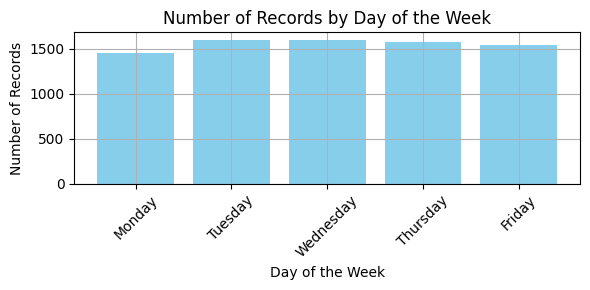

In [53]:
def plot_weekday_counts(df, date_column='Date'):
    """
    Calculates and plots the count of records for each weekday in the dataset.
    Parameters:
    -----------
    df : pd.DataFrame
        The DataFrame containing the stock data.
    date_column : str, default 'Date'
        The column with date values.
    Returns:
    --------
    pd.Series
        Series with weekdays as index and counts as values.
    """
    # Create a column for the day of the week (0=Monday, 6=Sunday)
    df['DayOfWeek'] = df[date_column].dt.day_name()

    # Count the number of records for each weekday
    weekday_counts = df['DayOfWeek'].value_counts().reindex(
        ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'], fill_value=0
    )

    # Display the counts
    print("\nCount of records by weekday:")
    print(weekday_counts)

    # Plot the counts as a bar chart
    plt.figure(figsize=(6, 3))
    plt.bar(weekday_counts.index, weekday_counts.values, color='skyblue')
    plt.xlabel('Day of the Week')
    plt.ylabel('Number of Records')
    plt.title('Number of Records by Day of the Week')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return weekday_counts

# Example usage
weekday_counts = plot_weekday_counts(df, date_column='Date')


In [59]:
df = df.dropna()

In [60]:
# the number of records with null values or 0 in dataset for each column
for col in df.columns:
    null_count = df[col].isnull().sum()
    zero_count = (df[col] == 0).sum()
    print(f"'{col}': Null values - {null_count}, Zero values - {zero_count}")


'Date': Null values - 0, Zero values - 0
'Adj Close': Null values - 0, Zero values - 0
'Close': Null values - 0, Zero values - 0
'High': Null values - 0, Zero values - 0
'Low': Null values - 0, Zero values - 0
'Open': Null values - 0, Zero values - 0
'Volume': Null values - 0, Zero values - 0
'Year': Null values - 0, Zero values - 0
'DayOfWeek': Null values - 0, Zero values - 0
'DayName': Null values - 0, Zero values - 0


In [63]:
def analyze_x_by_y(
    df,
    x_column='Open',
    y_column='DayOfMonth',
    date_column='Date',
    regulate=False
):
    """
    Analyzes the distribution and outlier counts of a variable x grouped by a time-based feature y.
    Allows regulation of the data based on the count of records per y value.

    Parameters:
    -----------
    df : pd.DataFrame
        The DataFrame containing the stock data.
    x_column : str, default 'Open'
        The column to analyze ('Open', 'Close', 'High', 'Low', 'Volume').
    y_column : str, default 'DayOfMonth'
        The column indicating the time-based grouping ('DayOfMonth', 'DayOfYear',
        'WeekNumber', 'DayOfWeek', 'WeekNoInMonth').
    date_column : str, default 'Date'
        The date column used to extract time-based features.
    regulate : bool, default False
        If True, normalizes the values of x by the count of records per y.

    Returns:
    --------
    None
    """

    from scipy import stats

    # Extract the desired time-based feature into y_column
    if y_column == 'DayOfMonth':
        df[y_column] = df[date_column].dt.day
    elif y_column == 'DayOfYear':
        df[y_column] = df[date_column].dt.dayofyear
    elif y_column == 'WeekNumber':
        df[y_column] = df[date_column].dt.isocalendar().week
    elif y_column == 'DayOfWeek':
        df[y_column] = df[date_column].dt.weekday  # Fixed: Removed parentheses
    elif y_column == 'WeekNoInMonth':
        df[y_column] = df[date_column].apply(lambda x: (x.day - 1) // 7 + 1)
    else:
        raise ValueError(f"Unsupported y_column: {y_column}")

    # 1. Count of Records by the y Column (C)
    record_counts = df[y_column].value_counts().sort_index()

    # print(f"\nCount of records by {y_column} (C):")
    # print(record_counts)

    # 2. Regulation of x if needed
    if regulate:
        df['Regulated_x'] = df[x_column] / df[y_column].map(record_counts)
        x_column = 'Regulated_x'

    # 3. Box Plot of x by y
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=y_column, y=x_column, data=df)
    plt.xlabel(y_column)
    plt.ylabel(f'{x_column} Value ({"Regulated" if regulate else "Raw"})')
    plt.title(f'Distribution of {x_column} by {y_column} {"(Regulated)" if regulate else ""}')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.show()

    # 4. Outlier Count of x by y (Normalized by Record Count)
    outlier_counts = {}
    normalized_outliers = {}

    for y_value, group in df.groupby(y_column):
        # Calculate Q1, Q3, and IQR
        Q1 = group[x_column].quantile(0.25)
        Q3 = group[x_column].quantile(0.75)
        IQR = Q3 - Q1

        # Define outlier boundaries
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Count outliers
        outliers = group[(group[x_column] < lower_bound) | (group[x_column] > upper_bound)]
        outlier_counts[y_value] = len(outliers)

        # Normalized outlier count by total records for the day
        if y_value in record_counts.index and record_counts[y_value] != 0:
            normalized_outliers[y_value] = len(outliers) / record_counts[y_value]
        else:
            normalized_outliers[y_value] = 0

    print(f"\nOutlier counts by {y_column}:")
    print(outlier_counts)

    print(f"\nNormalized outlier counts (outliers/C) by {y_column}:")
    print(normalized_outliers)

    # Plot normalized outlier count by y
    plt.figure(figsize=(6, 3))
    plt.bar(normalized_outliers.keys(), normalized_outliers.values(), color='orange')
    plt.xlabel(y_column)
    plt.ylabel('Normalized Outlier Count (Outliers/C)')
    plt.title(f'Outlier Proportion of {x_column} by {y_column} {"(Regulated)" if regulate else ""}')
    plt.grid(True)
    plt.tight_layout()
    plt.xticks(rotation=45)
    plt.show()

    # 5. ANOVA Test on x by y
    groups = [group[x_column].dropna() for _, group in df.groupby(y_column)]
    f_stat, p_value = stats.f_oneway(*groups)

    print(f"\nANOVA Test Results for {x_column} by {y_column}:")
    print(f"F-statistic: {f_stat:.4f}")
    print(f"p-value: {p_value:.4f}")

    if p_value < 0.05:
        print(f"Statistically significant difference in {x_column} by {y_column}.")
    else:
        print(f"No statistically significant difference in {x_column} by {y_column}.")

    # 6. Correlation Test of x with y (if y is numeric)
    if pd.api.types.is_numeric_dtype(df[y_column]):
        correlation, corr_p_value = stats.pearsonr(df[y_column], df[x_column])
        print(f"\nCorrelation between {x_column} and {y_column}:")
        print(f"Correlation coefficient: {correlation:.4f}")
        print(f"p-value: {corr_p_value:.4f}")

        if corr_p_value < 0.05:
            print(f"Statistically significant correlation between {x_column} and {y_column}.")
        else:
            print(f"No statistically significant correlation between {x_column} and {y_column}.")
    else:
        print(f"\nCannot perform correlation test for non-numeric y_column: {y_column}")


In [64]:
def test_all_combinations(df, date_column='Date', regulateOn=False):
    """
    Tests all possible combinations of x (price metrics) and y (time-based features)
    with optional regulation.

    Parameters:
    -----------
    df : pd.DataFrame
        The DataFrame containing the stock data.
    date_column : str, default 'Date'
        The column containing date information.
    regulateOn : bool, default False
        If True, regulation will be applied to normalize data by record counts.

    Returns:
    --------
    None
    """

    # Possible x (price metric) and y (time-based feature) values
    # x_columns = ['Open', 'Close', 'High', 'Low', 'Volume']
    # y_columns = ['DayOfMonth', 'DayOfYear', 'WeekNumber', 'DayOfWeek', 'WeekNoInMonth']
    x_columns = ['Close', 'Volume']
    y_columns = ['DayOfMonth', 'WeekNumber', 'DayOfWeek', 'WeekNoInMonth']

    # Iterate over all combinations of x, y, and regulation
    for x in x_columns:
        for y in y_columns:
            print(f"\n=== Analyzing {x} by {y} (Regulated: {regulateOn}) ===")
            try:
                analyze_x_by_y(
                    df,
                    x_column=x,
                    y_column=y,
                    date_column=date_column,
                    regulate=regulateOn
                )
            except Exception as e:
                print(f"Error while analyzing {x} by {y} (Regulated: {regulateOn})")
                print(f"Error: {e}")



=== Analyzing Close by DayOfMonth (Regulated: False) ===


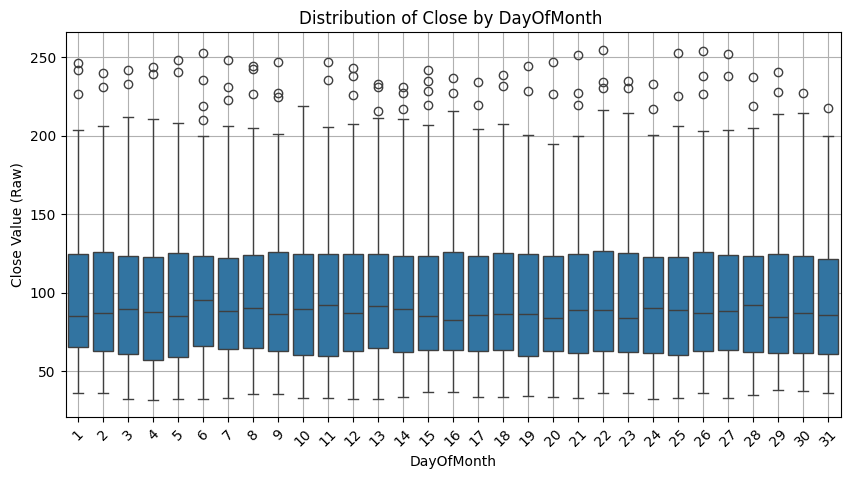


Outlier counts by DayOfMonth:
{1: 3, 2: 2, 3: 2, 4: 2, 5: 2, 6: 4, 7: 3, 8: 3, 9: 3, 10: 0, 11: 2, 12: 3, 13: 3, 14: 3, 15: 4, 16: 2, 17: 2, 18: 2, 19: 2, 20: 2, 21: 3, 22: 3, 23: 2, 24: 2, 25: 2, 26: 3, 27: 2, 28: 2, 29: 2, 30: 1, 31: 1}

Normalized outlier counts (outliers/C) by DayOfMonth:
{1: 0.013043478260869565, 2: 0.00847457627118644, 3: 0.008298755186721992, 4: 0.008968609865470852, 5: 0.008368200836820083, 6: 0.016194331983805668, 7: 0.0125, 8: 0.012145748987854251, 9: 0.012, 10: 0.0, 11: 0.00816326530612245, 12: 0.011857707509881422, 13: 0.012195121951219513, 14: 0.012244897959183673, 15: 0.016260162601626018, 16: 0.008064516129032258, 17: 0.008368200836820083, 18: 0.008298755186721992, 19: 0.008368200836820083, 20: 0.008438818565400843, 21: 0.012345679012345678, 22: 0.012345679012345678, 23: 0.00796812749003984, 24: 0.008733624454148471, 25: 0.00909090909090909, 26: 0.012875536480686695, 27: 0.008368200836820083, 28: 0.00847457627118644, 29: 0.008771929824561403, 30: 0.0045

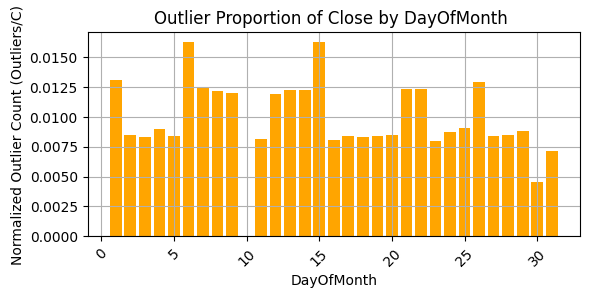


ANOVA Test Results for Close by DayOfMonth:
F-statistic: 0.0905
p-value: 1.0000
No statistically significant difference in Close by DayOfMonth.

Correlation between Close and DayOfMonth:
Correlation coefficient: -0.0057
p-value: 0.6236
No statistically significant correlation between Close and DayOfMonth.

=== Analyzing Close by WeekNumber (Regulated: False) ===


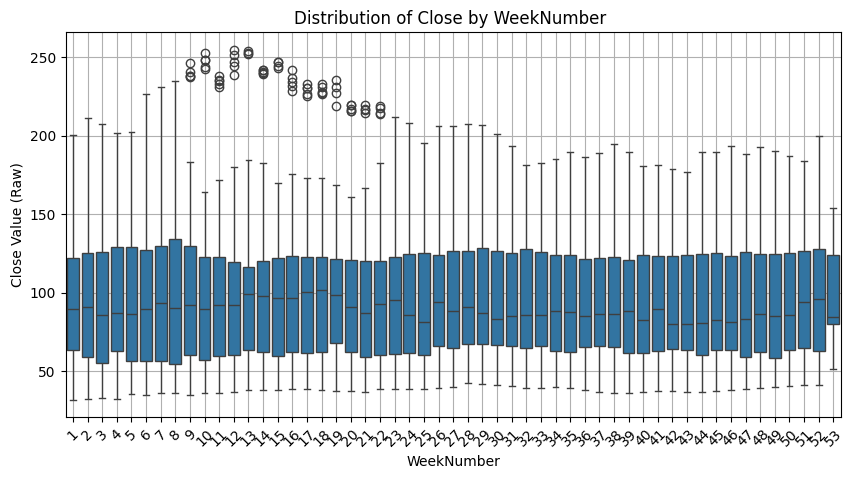


Outlier counts by WeekNumber:
{1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 5, 10: 5, 11: 5, 12: 5, 13: 3, 14: 5, 15: 4, 16: 5, 17: 5, 18: 5, 19: 4, 20: 5, 21: 4, 22: 4, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0, 48: 0, 49: 0, 50: 0, 51: 0, 52: 0, 53: 0}

Normalized outlier counts (outliers/C) by WeekNumber:
{1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.033783783783783786, 10: 0.034013605442176874, 11: 0.034722222222222224, 12: 0.03597122302158273, 13: 0.021897810218978103, 14: 0.03496503496503497, 15: 0.029197080291970802, 16: 0.03496503496503497, 17: 0.035211267605633804, 18: 0.03424657534246575, 19: 0.027586206896551724, 20: 0.03355704697986577, 21: 0.027777777777777776, 22: 0.03305785123966942, 23: 0.0, 24: 0.0, 25: 0.0, 26: 0.0, 27: 0.0, 28: 0.0, 29: 0.0, 30: 0.0, 31: 0.0, 32: 0.0, 33: 0.0, 34: 0.0, 35: 0.0, 36: 0.0, 37:

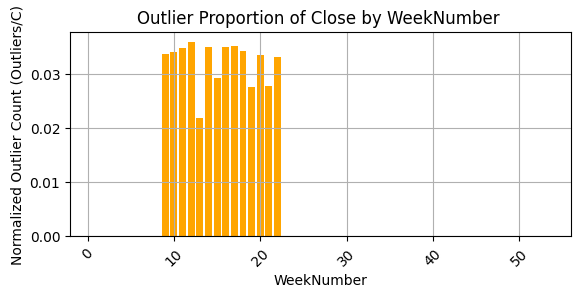


ANOVA Test Results for Close by WeekNumber:
F-statistic: 0.0958
p-value: 1.0000
No statistically significant difference in Close by WeekNumber.

Correlation between Close and WeekNumber:
Correlation coefficient: 0.0076
p-value: 0.5178
No statistically significant correlation between Close and WeekNumber.

=== Analyzing Close by DayOfWeek (Regulated: False) ===


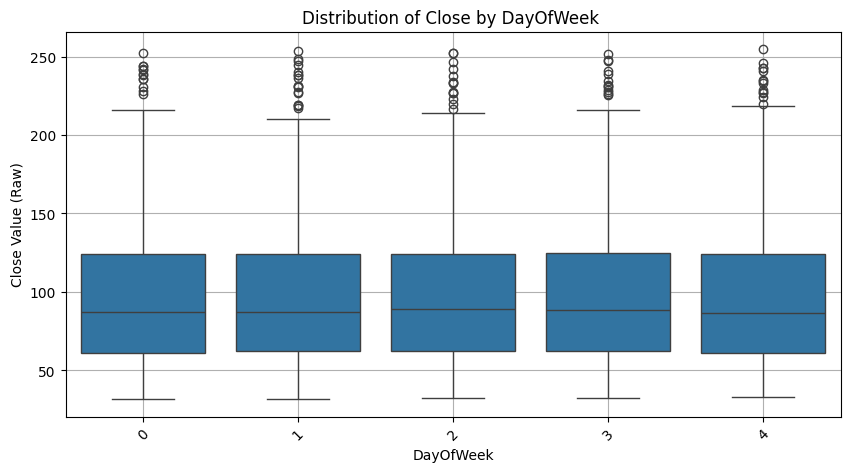


Outlier counts by DayOfWeek:
{0: 12, 1: 17, 2: 14, 3: 13, 4: 13}

Normalized outlier counts (outliers/C) by DayOfWeek:
{0: 0.008784773060029283, 1: 0.011273209549071617, 2: 0.009308510638297872, 3: 0.008777852802160702, 4: 0.008873720136518772}


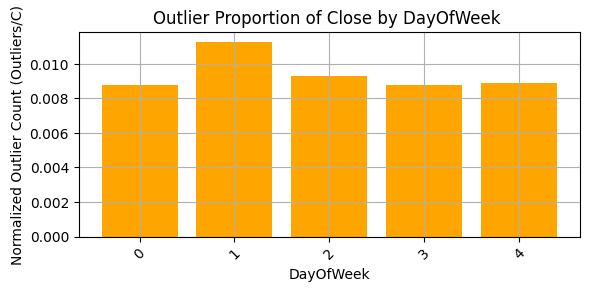


ANOVA Test Results for Close by DayOfWeek:
F-statistic: 0.0276
p-value: 0.9985
No statistically significant difference in Close by DayOfWeek.

Correlation between Close and DayOfWeek:
Correlation coefficient: 0.0022
p-value: 0.8483
No statistically significant correlation between Close and DayOfWeek.

=== Analyzing Close by WeekNoInMonth (Regulated: False) ===


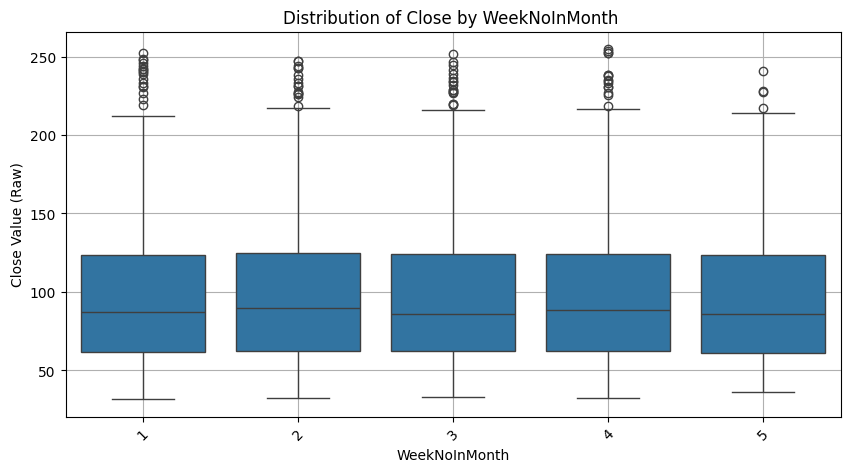


Outlier counts by WeekNoInMonth:
{1: 17, 2: 16, 3: 17, 4: 15, 5: 4}

Normalized outlier counts (outliers/C) by WeekNoInMonth:
{1: 0.010265700483091788, 2: 0.00922722029988466, 3: 0.01004134672179563, 4: 0.009085402786190187, 5: 0.006779661016949152}


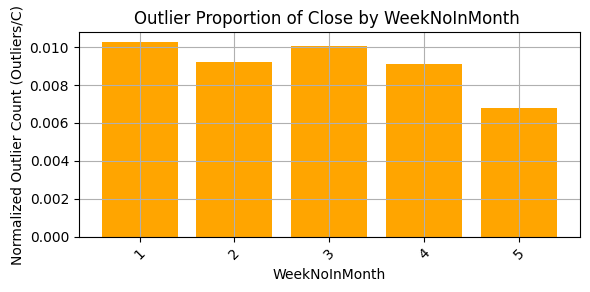


ANOVA Test Results for Close by WeekNoInMonth:
F-statistic: 0.1536
p-value: 0.9614
No statistically significant difference in Close by WeekNoInMonth.

Correlation between Close and WeekNoInMonth:
Correlation coefficient: -0.0050
p-value: 0.6673
No statistically significant correlation between Close and WeekNoInMonth.

=== Analyzing Volume by DayOfMonth (Regulated: False) ===


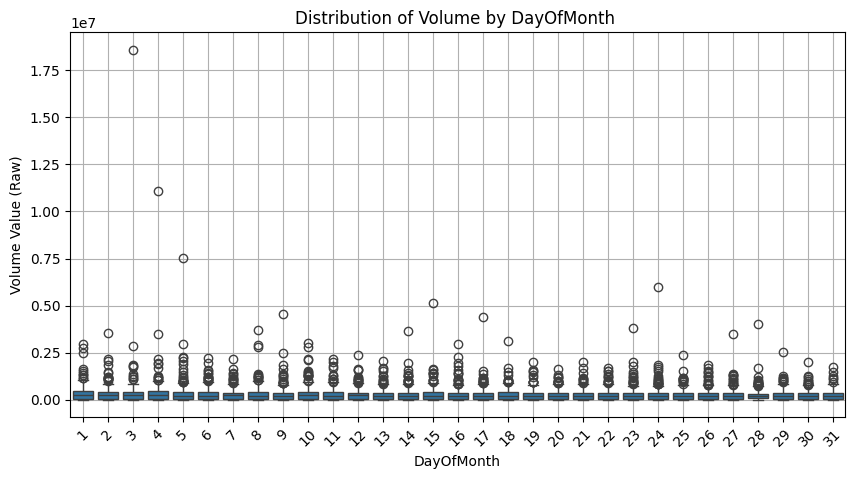


Outlier counts by DayOfMonth:
{1: 10, 2: 15, 3: 10, 4: 12, 5: 19, 6: 15, 7: 12, 8: 12, 9: 16, 10: 15, 11: 11, 12: 13, 13: 13, 14: 16, 15: 13, 16: 17, 17: 14, 18: 11, 19: 11, 20: 13, 21: 10, 22: 13, 23: 16, 24: 18, 25: 12, 26: 16, 27: 13, 28: 15, 29: 9, 30: 12, 31: 6}

Normalized outlier counts (outliers/C) by DayOfMonth:
{1: 0.043478260869565216, 2: 0.0635593220338983, 3: 0.04149377593360996, 4: 0.053811659192825115, 5: 0.0794979079497908, 6: 0.06072874493927125, 7: 0.05, 8: 0.048582995951417005, 9: 0.064, 10: 0.06048387096774194, 11: 0.044897959183673466, 12: 0.05138339920948617, 13: 0.052845528455284556, 14: 0.0653061224489796, 15: 0.052845528455284556, 16: 0.06854838709677419, 17: 0.058577405857740586, 18: 0.04564315352697095, 19: 0.04602510460251046, 20: 0.05485232067510549, 21: 0.0411522633744856, 22: 0.053497942386831275, 23: 0.06374501992031872, 24: 0.07860262008733625, 25: 0.05454545454545454, 26: 0.06866952789699571, 27: 0.05439330543933055, 28: 0.0635593220338983, 29: 0.0394

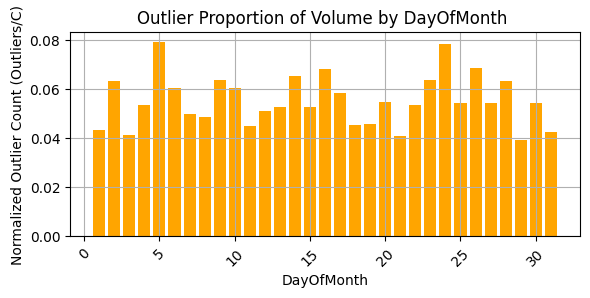


ANOVA Test Results for Volume by DayOfMonth:
F-statistic: 1.1584
p-value: 0.2524
No statistically significant difference in Volume by DayOfMonth.

Correlation between Volume and DayOfMonth:
Correlation coefficient: -0.0563
p-value: 0.0000
Statistically significant correlation between Volume and DayOfMonth.

=== Analyzing Volume by WeekNumber (Regulated: False) ===


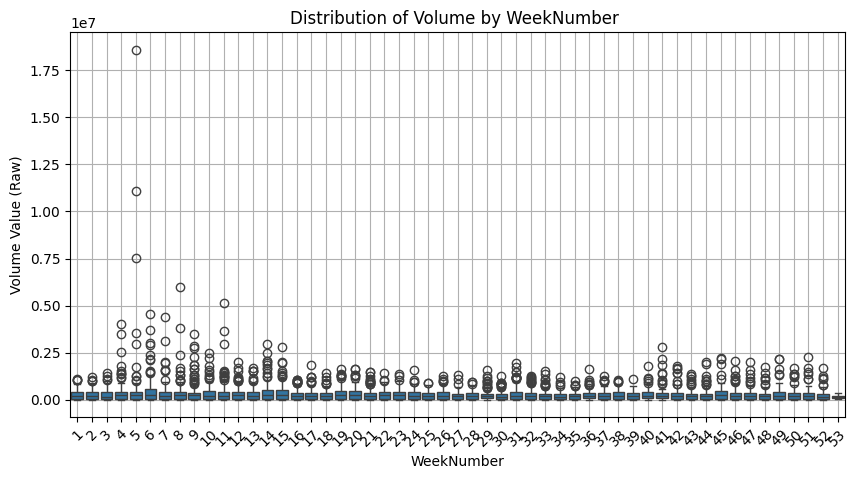


Outlier counts by WeekNumber:
{1: 4, 2: 4, 3: 4, 4: 10, 5: 10, 6: 10, 7: 8, 8: 11, 9: 17, 10: 9, 11: 13, 12: 10, 13: 7, 14: 11, 15: 8, 16: 10, 17: 8, 18: 7, 19: 7, 20: 6, 21: 13, 22: 3, 23: 3, 24: 4, 25: 2, 26: 5, 27: 3, 28: 3, 29: 13, 30: 12, 31: 12, 32: 10, 33: 10, 34: 4, 35: 5, 36: 8, 37: 5, 38: 4, 39: 1, 40: 5, 41: 9, 42: 8, 43: 8, 44: 10, 45: 5, 46: 8, 47: 7, 48: 7, 49: 5, 50: 6, 51: 6, 52: 6, 53: 0}

Normalized outlier counts (outliers/C) by WeekNumber:
{1: 0.031746031746031744, 2: 0.028368794326241134, 3: 0.031746031746031744, 4: 0.07194244604316546, 5: 0.06896551724137931, 6: 0.06802721088435375, 7: 0.05555555555555555, 8: 0.09166666666666666, 9: 0.11486486486486487, 10: 0.061224489795918366, 11: 0.09027777777777778, 12: 0.07194244604316546, 13: 0.051094890510948905, 14: 0.07692307692307693, 15: 0.058394160583941604, 16: 0.06993006993006994, 17: 0.056338028169014086, 18: 0.04794520547945205, 19: 0.04827586206896552, 20: 0.040268456375838924, 21: 0.09027777777777778, 22: 0.0247

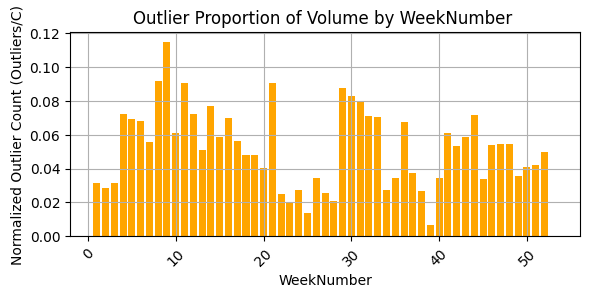


ANOVA Test Results for Volume by WeekNumber:
F-statistic: 3.0236
p-value: 0.0000
Statistically significant difference in Volume by WeekNumber.

Correlation between Volume and WeekNumber:
Correlation coefficient: -0.0828
p-value: 0.0000
Statistically significant correlation between Volume and WeekNumber.

=== Analyzing Volume by DayOfWeek (Regulated: False) ===


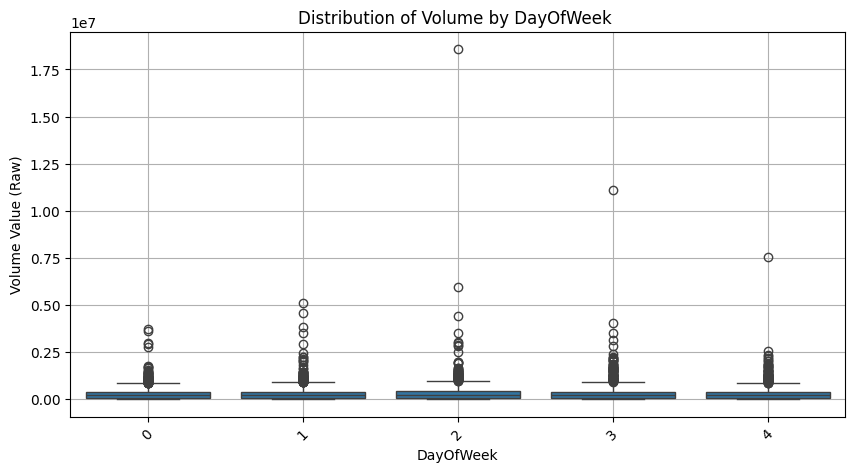


Outlier counts by DayOfWeek:
{0: 77, 1: 77, 2: 78, 3: 80, 4: 75}

Normalized outlier counts (outliers/C) by DayOfWeek:
{0: 0.05636896046852123, 1: 0.05106100795755968, 2: 0.05186170212765957, 3: 0.05401755570560432, 4: 0.051194539249146756}


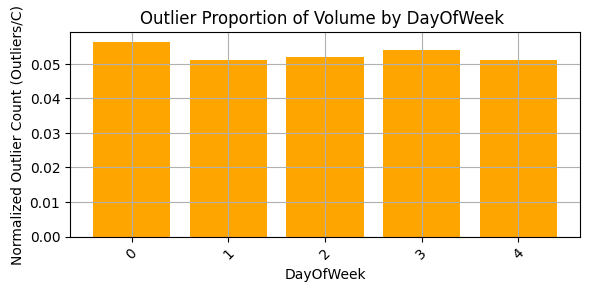


ANOVA Test Results for Volume by DayOfWeek:
F-statistic: 2.5753
p-value: 0.0357
Statistically significant difference in Volume by DayOfWeek.

Correlation between Volume and DayOfWeek:
Correlation coefficient: 0.0077
p-value: 0.5121
No statistically significant correlation between Volume and DayOfWeek.

=== Analyzing Volume by WeekNoInMonth (Regulated: False) ===


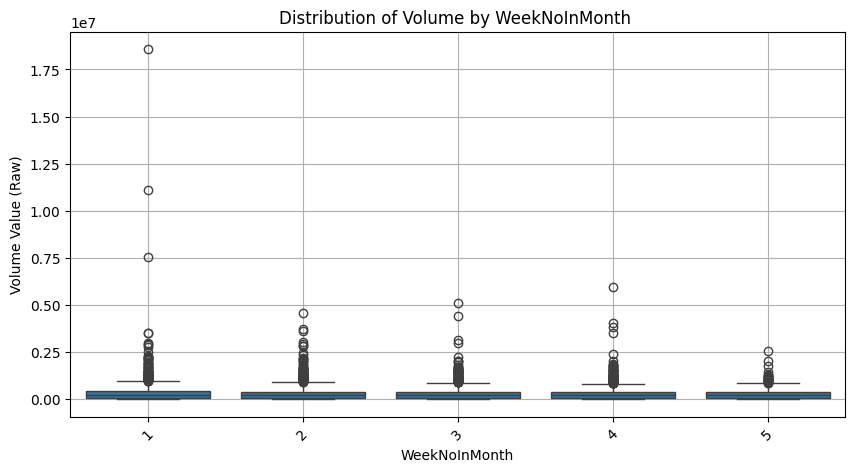


Outlier counts by WeekNoInMonth:
{1: 95, 2: 92, 3: 86, 4: 98, 5: 25}

Normalized outlier counts (outliers/C) by WeekNoInMonth:
{1: 0.057367149758454104, 2: 0.0530565167243368, 3: 0.050797401063201415, 4: 0.059357964869775896, 5: 0.0423728813559322}


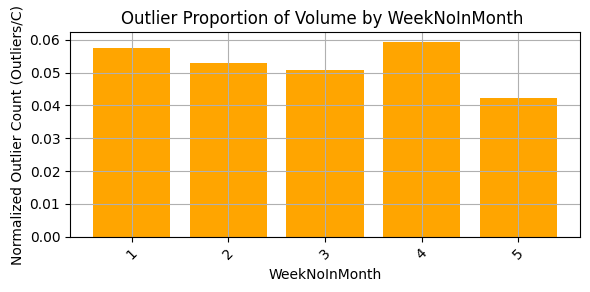


ANOVA Test Results for Volume by WeekNoInMonth:
F-statistic: 5.4533
p-value: 0.0002
Statistically significant difference in Volume by WeekNoInMonth.

Correlation between Volume and WeekNoInMonth:
Correlation coefficient: -0.0527
p-value: 0.0000
Statistically significant correlation between Volume and WeekNoInMonth.


In [65]:
test_all_combinations(df, date_column='Date', regulateOn=False)



Top 40 Transformed Features by Correlation with 'Close':
     Close_RollingMean_window1: Correlation = 1.0000, p-value = 0.0000
      High_RollingMean_window1: Correlation = 0.9999, p-value = 0.0000
       Low_RollingMean_window1: Correlation = 0.9999, p-value = 0.0000
     Close_RollingMean_window2: Correlation = 0.9998, p-value = 0.0000
       Low_RollingMean_window2: Correlation = 0.9997, p-value = 0.0000
      High_RollingMean_window2: Correlation = 0.9997, p-value = 0.0000
     Close_RollingMean_window3: Correlation = 0.9996, p-value = 0.0000
    Volume_RollingMean_window7: Correlation = 0.1296, p-value = 0.0000
    Volume_RollingMean_window6: Correlation = 0.1279, p-value = 0.0000
         Volume_PctChange_lag3: Correlation = -0.1264, p-value = 0.0000
    Volume_RollingMean_window5: Correlation = 0.1261, p-value = 0.0000
         Volume_PctChange_lag2: Correlation = -0.1260, p-value = 0.0000
         Volume_PctChange_lag1: Correlation = -0.1239, p-value = 0.0000
    Volume_Rolli

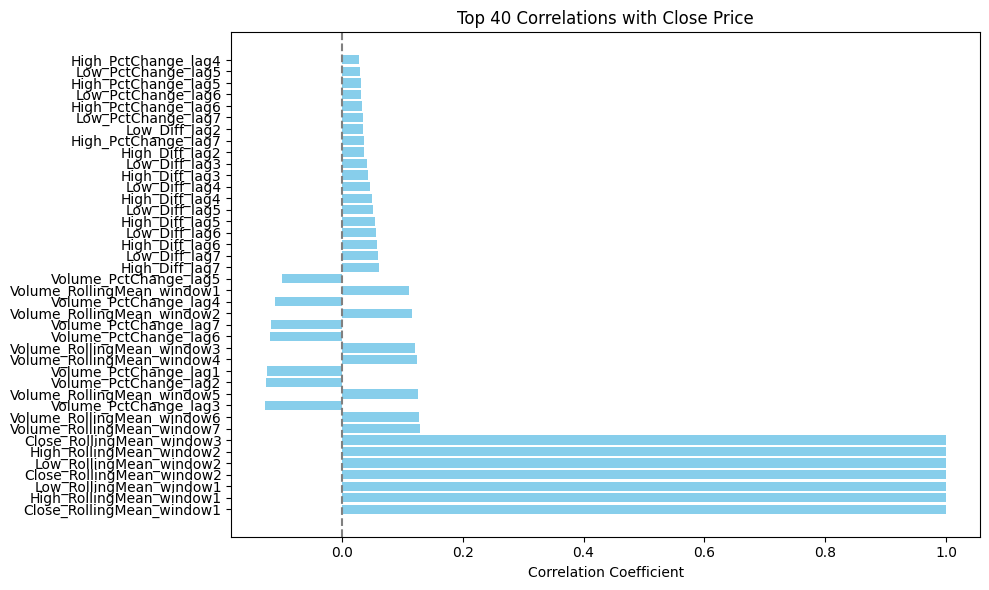

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def evaluate_correlations_with_close(
    df,
    date_column='Date',
    transformations=None,
    top_n=10
):
    """
    Evaluates which transformed feature (from Volume, High, Low) best correlates with the Close price.
    Allows custom transformations and controls the number of top features displayed.

    Parameters:
    -----------
    df : pd.DataFrame
        The DataFrame containing the stock data.
    date_column : str, default 'Date'
        The date column used for sorting the data.
    transformations : list of dict, optional
        Custom transformations to apply. Each dict should have:
        - 'y_column': the column to transform ('Volume', 'High', 'Low').
        - 'y_transform': the transformation ('RollingMean', 'Diff', 'PctChange').
        - 'param_name': the parameter name ('window' for rolling, 'lag' for diff/pct change).
        - 'param_range': range of parameter values to try.
        Example: {'y_column': 'Volume', 'y_transform': 'Lagged', 'param_name': 'lag', 'param_range': range(1, 4)}.
    top_n : int, default 10
        The number of top features to display based on correlation with 'Close'.

    Returns:
    --------
    None
    """

    # Ensure data is sorted by date
    df = df.sort_values(by=date_column)

    # Default transformations if none are provided
    if transformations is None:
        y_columns = ['Volume', 'High', 'Low']
        transformations = [
            {'y_column': y_col, 'y_transform': 'RollingMean', 'param_name': 'window', 'param_range': range(1, 4)} for y_col in y_columns
        ] + [
            {'y_column': y_col, 'y_transform': 'Diff', 'param_name': 'lag', 'param_range': range(1, 4)} for y_col in y_columns
        ] + [
            {'y_column': y_col, 'y_transform': 'PctChange', 'param_name': 'lag', 'param_range': range(1, 4)} for y_col in y_columns
        ]

    # Store results
    correlation_results = []

    # Iterate through custom transformations
    for transform in transformations:
        y_column = transform['y_column']
        y_transform = transform['y_transform']
        param_name = transform['param_name']

        for param_value in transform['param_range']:
            # Generate the transformed y_column
            transformed_y_column = f'{y_column}_{y_transform}_{param_name}{param_value}'

            # Apply the transformation
            if y_transform == 'RollingMean':
                df[transformed_y_column] = df[y_column].rolling(window=param_value).mean()
            elif y_transform == 'Diff':
                df[transformed_y_column] = df[y_column].diff(periods=param_value)
            elif y_transform == 'PctChange':
                df[transformed_y_column] = df[y_column].pct_change(periods=param_value)

            # Drop NaNs before correlation
            temp_df = df.dropna(subset=['Close', transformed_y_column])

            # Calculate correlation
            if not temp_df.empty:
                correlation, p_value = stats.pearsonr(temp_df['Close'], temp_df[transformed_y_column])
                correlation_results.append({
                    'Feature': transformed_y_column,
                    'Correlation': correlation,
                    'p-value': p_value
                })

    # Sort by absolute correlation value
    correlation_results = sorted(correlation_results, key=lambda x: abs(x['Correlation']), reverse=True)

    # Display top results
    print(f"\nTop {top_n} Transformed Features by Correlation with 'Close':")
    for result in correlation_results[:top_n]:
        print(f"{result['Feature']:>30}: Correlation = {result['Correlation']:.4f}, p-value = {result['p-value']:.4f}")

    # Visualize correlations
    plt.figure(figsize=(10, 6))
    features = [result['Feature'] for result in correlation_results[:top_n]]
    correlations = [result['Correlation'] for result in correlation_results[:top_n]]

    plt.barh(features, correlations, color='skyblue')
    plt.xlabel('Correlation Coefficient')
    plt.title(f'Top {top_n} Correlations with Close Price')
    plt.axvline(x=0, color='gray', linestyle='--')
    plt.tight_layout()
    plt.show()

# Example usage with custom transformations and top 20 features:
custom_transformations = [
    {'y_column': 'Low', 'y_transform': 'RollingMean', 'param_name': 'window', 'param_range': range(1, 3)},
    {'y_column': 'Low', 'y_transform': 'Diff', 'param_name': 'lag', 'param_range': range(1, 8)},
    {'y_column': 'Low', 'y_transform': 'PctChange', 'param_name': 'lag', 'param_range': range(1, 8)},
    {'y_column': 'High', 'y_transform': 'RollingMean', 'param_name': 'window', 'param_range': range(1, 3)},
    {'y_column': 'High', 'y_transform': 'Diff', 'param_name': 'lag', 'param_range': range(1, 8)},
    {'y_column': 'High', 'y_transform': 'PctChange', 'param_name': 'lag', 'param_range': range(1, 8)},
    {'y_column': 'Volume', 'y_transform': 'RollingMean', 'param_name': 'window', 'param_range': range(1, 8)},
    {'y_column': 'Volume', 'y_transform': 'Diff', 'param_name': 'lag', 'param_range': range(1, 8)},
    {'y_column': 'Volume', 'y_transform': 'PctChange', 'param_name': 'lag', 'param_range': range(1, 8)},

    # {'y_column': 'Open', 'y_transform': 'RollingMean', 'param_name': 'window', 'param_range': range(1, 8)},
    {'y_column': 'Close', 'y_transform': 'RollingMean', 'param_name': 'window', 'param_range': range(1, 4)}


]

evaluate_correlations_with_close(df, date_column='Date', transformations=custom_transformations, top_n=40)
